## Classifier-free guidance (for class-aware data augmentation)

In [65]:
import importlib
from pathlib import Path
import sys
sys.path.append('..')
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.optim import Adam
import torchvision

from src.diffusion import classifier_free_guidance as cfg
from src import trainhelper as th
from src import dataset
from src import viz

importlib.reload(th)
importlib.reload(dataset)
importlib.reload(viz)

<module 'src.viz' from '/home/nashir/Documents/UCF/spring2023/cap5516/final-project/notebooks/../src/viz.py'>

## Load images, compute mean and std for normalization, then reload as downscaled

In [66]:
datadir = "../data/chest_xray"
dataloaders, dataset_sizes, class_names = dataset.load_xray_data(datadir, return_val_set=False, batch_size=4, load_as_rgb=False)
# Compute approximate mean and std of train dataset based on a single batch
images, _ = next(iter(dataloaders['train']))
# shape of images = [b,c,w,h]
mean, std = images.mean([0,2,3]), images.std([0,2,3])
# Reload downscaled dataset with mean and std computed above
transform = dataset.get_downscale_transforms(mean, std, load_as_rgb=False)
dataloaders, dataset_sizes, class_names = dataset.load_xray_data(datadir, transform, batch_size=4)

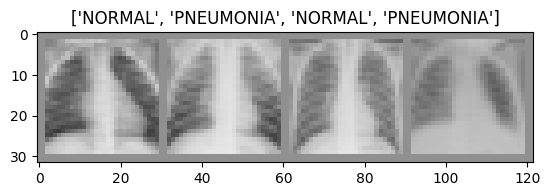

In [67]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['test']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

viz.imshow(out, mean, std, title=[class_names[x] for x in classes])

# Train diffusion on downsampled images, 28x28

In [68]:
image_size = 28
channels = 1
timesteps = 500
log_every = 100
lr = 0.0001
batch_size = 4

In [69]:
# xray
label_map = {
    0: "Normal",
    1: "Pneumonia"
}

In [70]:
dataloader = dataloaders['train']

In [71]:
num_classes = 2
channels = 1

model = cfg.Unet(
    dim = 64,
    channels=channels,
    dim_mults = (1, 2, 4,),
    num_classes = num_classes,
    cond_drop_prob = 0.5
)

optimizer = Adam(model.parameters(), lr=lr)

diffusion = cfg.GaussianDiffusion(
    model,
    image_size = image_size,
    timesteps = timesteps
).cuda()

device = "cuda" if torch.cuda.is_available() else "cpu"

In [72]:
results_folder = Path("../results")
results_folder.mkdir(exist_ok = True)
save_and_sample_every = 500

In [41]:
losses = []
epochs = 50

Starting training at 20230426-170018
Epoch 0
Loss at step 0: 0.4332937002182007
Loss at step 100: 0.33435991406440735
Loss at step 200: 0.45076286792755127
Loss at step 300: 0.32716113328933716
Loss at step 400: 0.20892998576164246
Loss at step 500: 0.31743761897087097
Loss at step 600: 0.30428993701934814
Loss at step 700: 0.32770460844039917
Loss at step 800: 0.4430893063545227
Loss at step 900: 0.3773314356803894
Loss at step 1000: 0.29959580302238464


sampling loop time step: 100%|██████████| 500/500 [00:27<00:00, 18.39it/s]


Finished training, saving model and losses


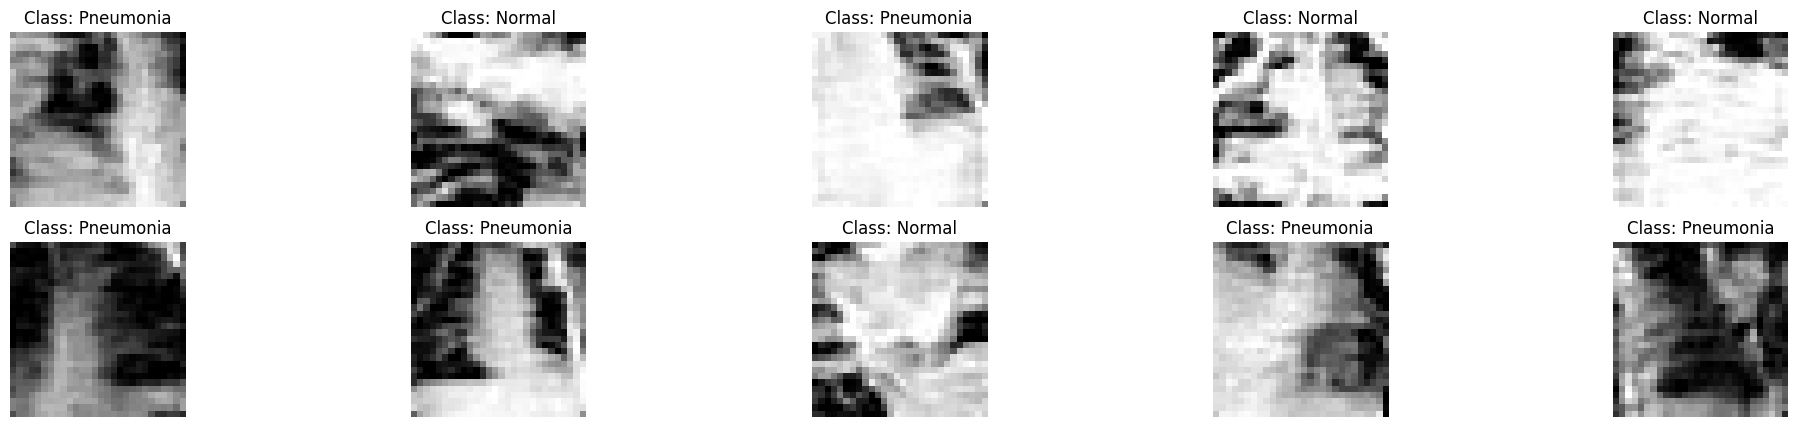

In [55]:
t0 = time.time()
th.train_classifier_free_guidance(epochs, model, dataloader, optimizer, device, diffusion,
                                  results_folder, label_map, losses, log_every,
                                  model_name="xray-unet", cond_scale=3.)
t1 = time.time()

In [56]:
print(f"Time taken to train for {epochs} epoch: {(t1 - t0) / 60:.3f} m")

Time taken to train for 1 epoch: 1.712 m


In [57]:
def flatten_list(l):
    return [item for sublist in l for item in sublist]
def average_nested_lists(l):
    return [sum(x) / len(x) for x in l]

In [58]:
len(losses), len(flatten_list(losses)), len(average_nested_lists(losses))

(3, 3141, 3)

In [64]:
n_steps_per_epoch = len(losses[0])
n_steps_per_epoch

1047

In [61]:
x_epoch_loss = [n_steps_per_epoch * (i + 1) for i in range(len(losses))]
y_epoch_loss = average_nested_lists(losses)

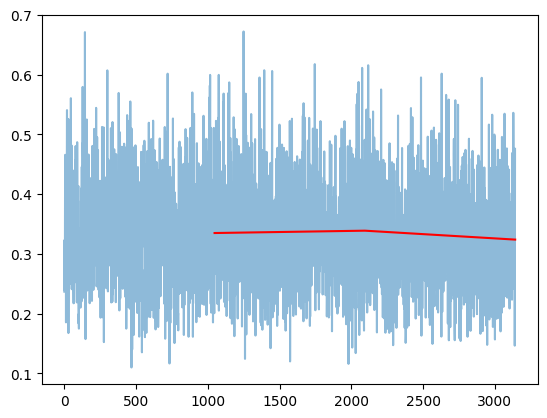

In [62]:
plt.plot(flatten_list(losses), alpha=0.5)
plt.plot(x_epoch_loss, y_epoch_loss, c='r')

In [52]:
sampled_images, image_classes = th.sample_n_images(diffusion, 10, 2, 3.)

sampling loop time step: 100%|██████████| 500/500 [00:26<00:00, 18.53it/s]


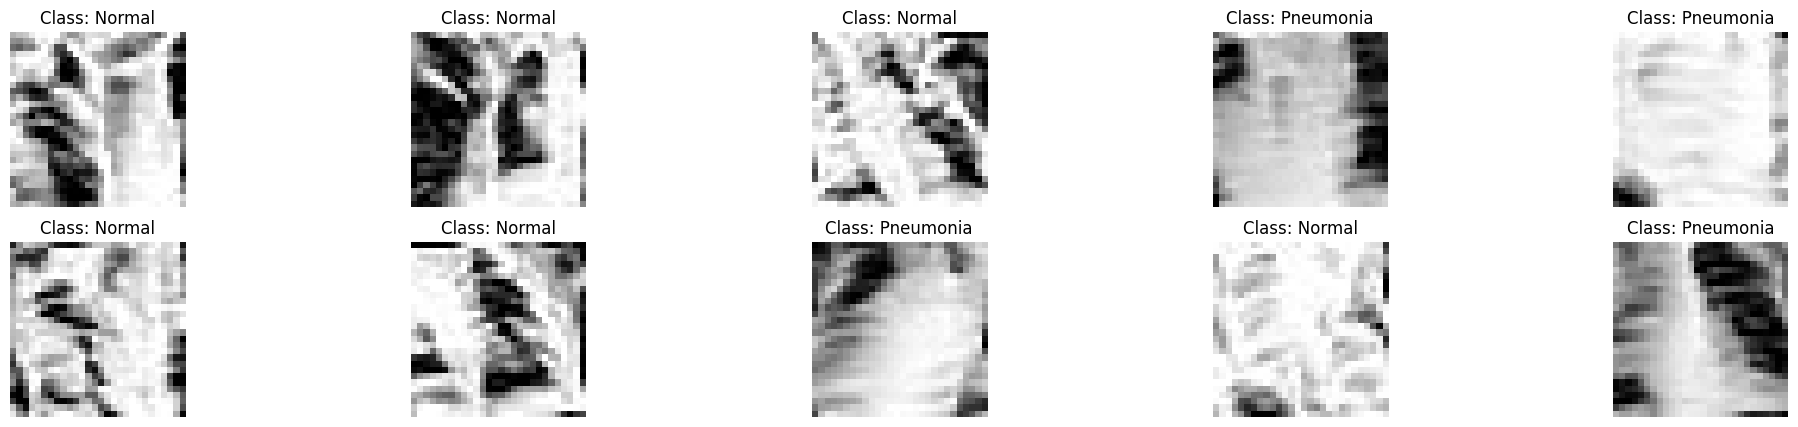

In [53]:
viz.plot_generated_images(sampled_images, image_classes, label_map)